# Advanced lane finding project

#### Dependencies

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
%matplotlib qt
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

os.chdir(r'C:\Users\1523774\Desktop\Ganbold\Udacity sdcnd\Project 2- Advanced lane finding')

### Camera calibration

Most cameras distort images due to their non-flat lens. In this section, we calibrate camera distortions will and find its distortionc coefficients and matrix using chessboard images which are taken by the camera

In [2]:
def cameraCalib(images_path, nx =9, ny =6):
    '''
    Args:
        images_path: path to images
        nx: number of inside corners in x
        ny: number of inside corners in y
    outputs: 
        objpoints: 3D object points in real world space
        imgpoints: 2D image points in image plane   
        '''
    # preparing object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # reshape it into x, y coordinates

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(images_path)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None) 

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    #         plt.imshow(img)
    #         plt.show()
    if len(objpoints) > 0:
        ret, mtx, dist_coef, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        print('\n...Camera calibration successfully done!...\n')
    else:
        print('\n...Unable to calibrate camera!...\n')
        ret, mtx, dist_coef, rvecs, tvecs = (None, None, None, None, None)
        
    return ret, mtx, dist_coef, rvecs, tvecs

ret, mtx, dist_coef, rvecs, tvecs = cameraCalib('camera_cal/calibration*.jpg')


...Camera calibration successfully done!...



### Distortion correction

Now that we know how much the camera distorts images and its distortion metrics, we can undistort the images. We will map distorted images back to undistorted images using camera distortion coefficients. 

In [3]:
#Undistortion function
def dist_cor(img, mtx, dist_coef):
    '''
    Args:
        img: image to be undistorted
        mtx: distortion matrix
        dist_coef: distortion coefficient 
    output: undistorted image
        '''
    undist = cv2.undistort(img, mtx, dist_coef, None, mtx)
    return undist

Plotting function

In [4]:
def plots(img1, img2, title1, title2, gray = (False, False), save = False):
    '''
    Args:
        img1: first image to be displayed
        img2: second image to be displayed
        title1: title for first image
        title2: title for second image
        gray: booleans for whether display in gray scale 
    output: displays 2 images side by side
    '''
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
    if gray[0]:
        ax1.imshow(img1, cmap='gray')
    else:
        ax1.imshow(img1)
    
    if gray[1]:
         ax2.imshow(img2, cmap='gray')
    else:
        ax2.imshow(img2)
    
    ax1.set_title(title1, fontsize = 18)
    ax2.set_title(title2, fontsize = 18)
    if save:
        plt.savefig('output_images/' + title2, bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    

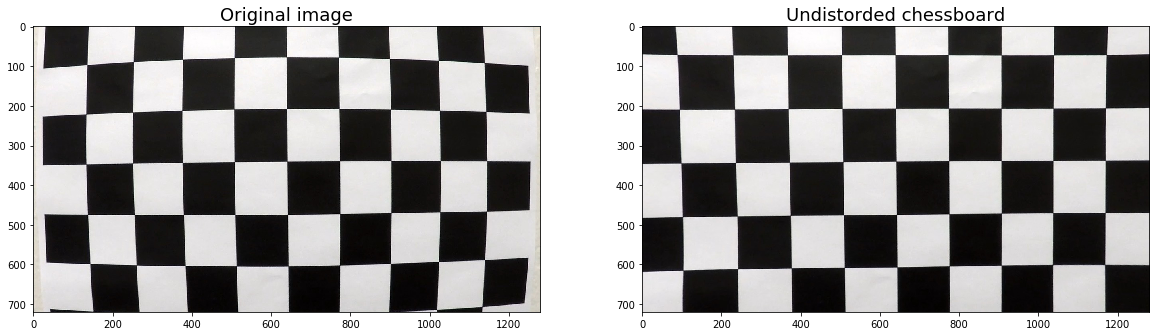

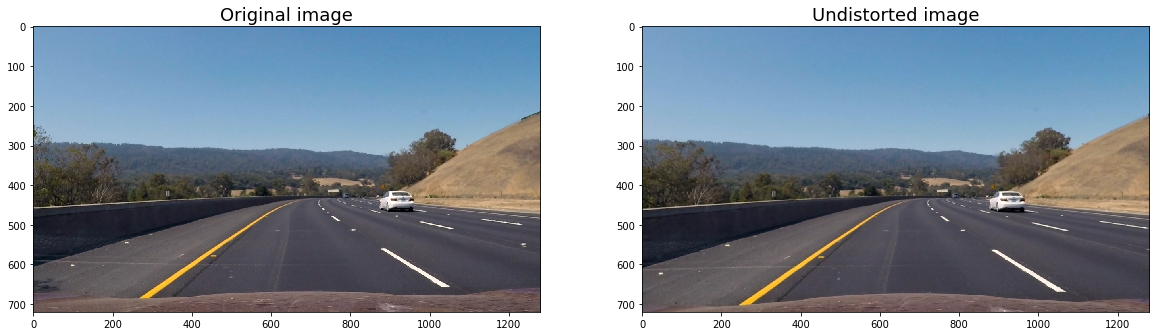

In [5]:
#Distortion correction for Chessboard image
chess = mpimg.imread(r'camera_cal/calibration1.jpg')
undist_ch = dist_cor(chess, mtx, dist_coef)
plots(chess, undist_ch, 'Original image', 'Undistorded chessboard', save=True)

#distortion correction for test_image
img = mpimg.imread(r'test_images\test3.jpg')
undist = dist_cor(img, mtx, dist_coef)
plots(img, undist, 'Original image', 'Undistorted image', save=True)

### Color/gradient threshold

In this section, using image pixel intensity and color information, we will try to identify lane lines.

#### Gradient thresholding

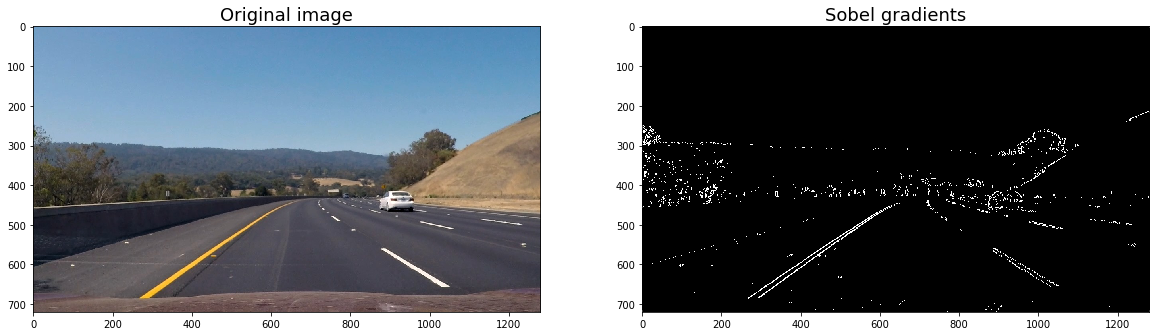

In [6]:
def sobel_thresh(img, orient='x', kernel = 3, thresh= (10,255)):
    '''
    Args:
        img: an image to be sobel-thresholded /oriental/
        orient: orientation for gradient
        kernel: kernel size 
        thresh: threshold for the gradient
    output: binary sobel-thresholded image
        '''
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        sobeled = cv2.Sobel(gray, cv2.CV_64F, 1, 0, kernel)
    elif orient == 'y':
        sobeled = cv2.Sobel(gray, cv2.CV_64F, 0, 1, kernel)
        
    abs_sobel = np.absolute(sobeled) #absolute magnitude
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) #scaling to 8 bit
    
    #Binary thresholding
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

#testing
sobel_output = sobel_thresh(img, orient='x', kernel = 15, thresh= (30,100))
plots(img, sobel_output, 'Original image', 'Sobel gradients', gray=(False, True),save=True)

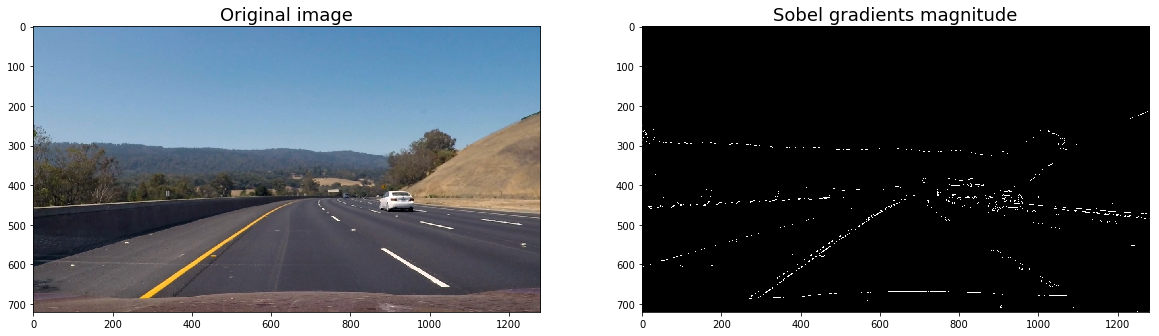

In [7]:
def mag_thresh(img, kernel=3, thresh=(0, 200)):
    '''
    Args:
        img: an image to be sobel-thresholded /magnitude/
        kernel: kernel size 
        thresh: threshold for the gradient
    output: binary sobel-thresholded/magnitude/ image
        '''
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, kernel)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    #scaling
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    #thresholding
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return mag_binary

#testing
mag_output = mag_thresh(img, kernel=10, thresh=(70, 100))
plots(img, mag_output, 'Original image', 'Sobel gradients magnitude', gray=(False, True),save=True)

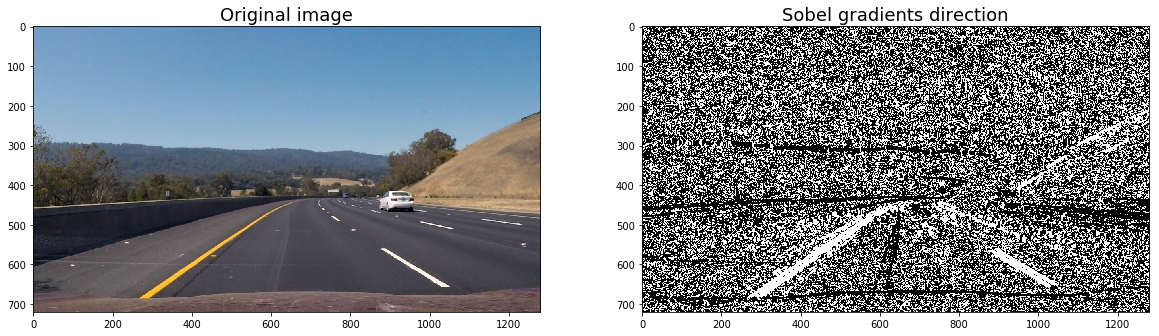

In [8]:
def dir_thresh(img, kernel=3, thresh=(0, np.pi/2)):
    '''
    Args:
        img: an image to be sobel-thresholded /directional/
        kernel: kernel size 
        thresh: threshold for the gradient
    output: binary sobel-thresholded/directional/ image
        '''
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    
    abs_sobelx=np.absolute(sobelx); abs_sobely=np.absolute(sobely)
    gra_dir = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(gra_dir)
    dir_binary[(gra_dir >= thresh[0]) & (gra_dir <= thresh[1])] = 1
    return dir_binary

dir_output = dir_thresh(img, kernel=15, thresh=(0.7, 1.3))
plots(img, dir_output, 'Original image', 'Sobel gradients direction', gray=(False, True),save=True)

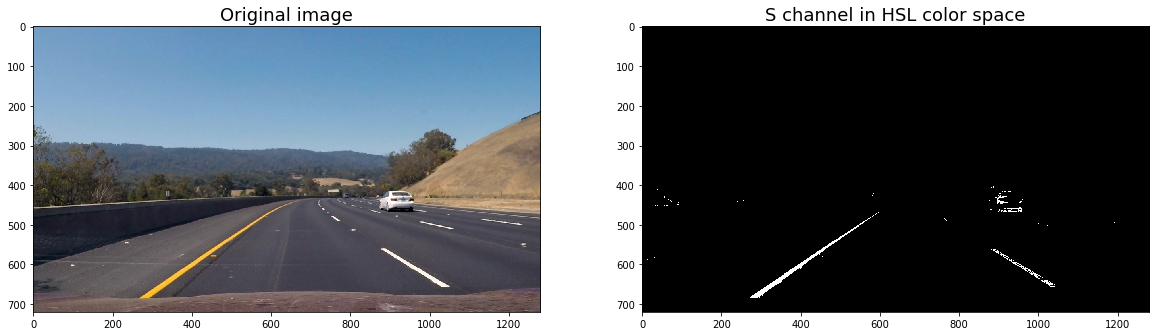

In [9]:
#Color thresholding
def col_thres(img, thresh=(90, 255)):
    '''
    Args:
        img: an image to be s-channel thresholded
        thresh: threshold for the color intensivity
    output: binary s channel thresholded image
    '''
    # Converting to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_chan = hls[:,:,2]
    
    # Applying a threshold to the S channel
    s_binary = np.zeros_like(s_chan)
    s_binary[(s_chan > thresh[0])&(s_chan<=thresh[1])] = 1
    return s_binary

col_output = col_thres(img, thresh=(170, 255))
plots(img, col_output, 'Original image', 'S channel in HSL color space', gray=(False, True),save=True)

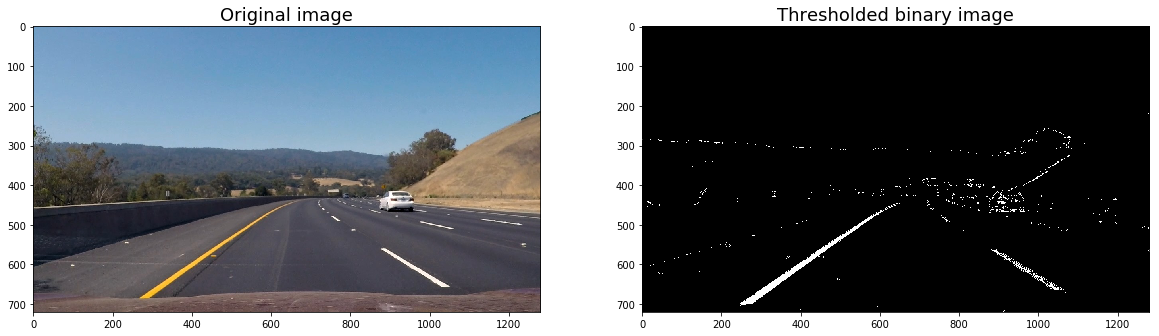

In [10]:
#thresholding pipeline
def threshold_pipe(img, so_thresh=(30, 100), col_thresh=(170, 255), m_thresh=(70, 100), d_thresh=(0.7, 1.3)):
    '''
    Applies various thresholding functions into a single image
    '''
    # Sobel
    sobel_x = sobel_thresh(img, orient='x', kernel = 15, thresh= so_thresh)
    sobel_y = sobel_thresh(img, orient='y', kernel = 15, thresh= so_thresh)
    # Threshold x gradient magnitude
    mag_binary = mag_thresh(img, kernel = 15, thresh=m_thresh)
    #Threshold on gradient direction
    dir_binary = dir_thresh(img, kernel=15, thresh=d_thresh)
    #Threshold on S channel
    col_binary = col_thres(img, thresh=col_thresh)

    #combining 
    thres_binary = np.zeros_like(img[:,:,2])
    thres_binary[((sobel_x == 1) & (sobel_y == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (col_binary == 1)] = 1
    
    return thres_binary

#test
thres_binary = threshold_pipe(undist)
plots(img, thres_binary, 'Original image', 'Thresholded binary image', (False, True), save = True)

### Perspective transform 

In perspective transform, we will transform front-camera view images into bird-eye view images.

#### Finding appropriate source points on the image

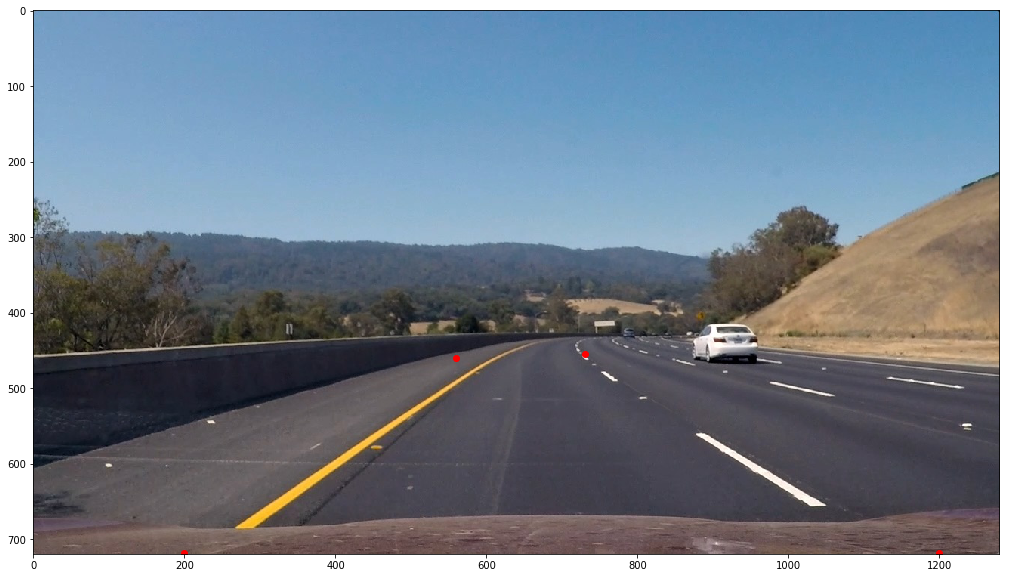

In [19]:
#Locating appropriate points
top_left = np.array([560, 460]).reshape(1, -1)
top_right = np.array([730, 455]).reshape(1, -1)
bottom_left = np.array([200, 719]).reshape(1, -1)
bottom_right = np.array([1200, 719]).reshape(1, -1)
src = np.float32([top_left, top_right, bottom_right, bottom_left])

#check it on images
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.plot(bottom_left[0][0], bottom_left[0][1], 'o', color='red')
plt.plot(bottom_right[0][0], bottom_right[0][1], 'o', color = 'red')
plt.plot(top_left[0][0],top_left[0][1], 'o', color = 'red')
plt.plot(top_right[0][0],top_right[0][1], 'o', color='red')

#### Perspective transform

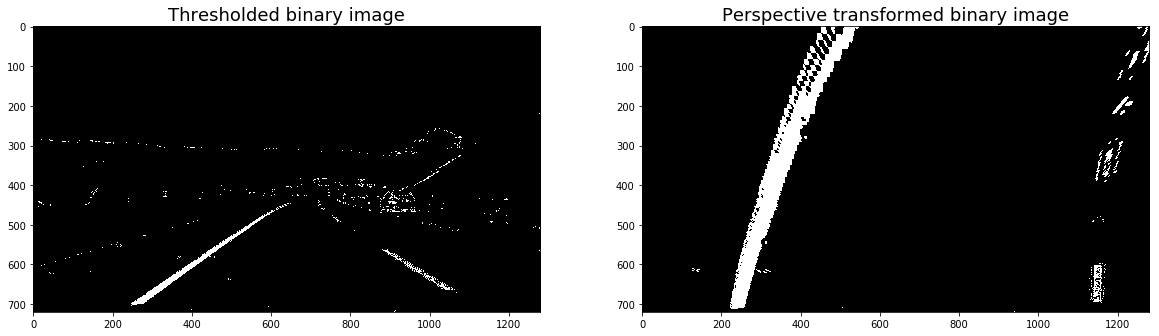

In [17]:
def pers_trans(undist, nx, src, offset = 100):
    '''
    Args:
        undist: undistorted image
        nx: number of corners along the x axis in the image
        corners: chess corners from camera calibration 
    output: 
        warped: a perspective transformed image
        M: transform matrix
        Minv: inverse transform matrix
        '''
    img_size = (img.shape[1], img.shape[0])
    dst = np.float32([[bottom_left[0][0] - offset, 0], 
                      [bottom_right[0][0] + offset, 0], 
                      [bottom_right[0][0], bottom_right[0][1]], 
                      [bottom_left[0][0], bottom_left[0][1]]]) 
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

#Testing 
warped, M, Minv = pers_trans(thres_binary, 9, src, offset =100)
plots(thres_binary, warped, 'Thresholded binary image', 'Perspective transformed binary image', (True, True), save = True)

### Lane line detection

In this section, our goal is to detect lane lines using histogram of pixel values of binary warped/perspective-transformed/ image.

#### Pixel Histogram 

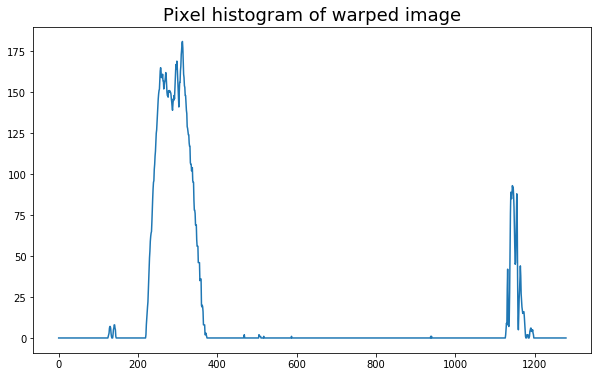

In [22]:
def hist(img):
    '''
    Plots histogram of bottom half of an image
    '''
    bottom_half = img[img.shape[0]//2:, :]
    histogram = np.sum(bottom_half, axis=0)
    return histogram

histogram = hist(warped)
plt.figure(figsize=(10,6))
plt.plot(histogram)
plt.title('Pixel histogram of warped image', fontsize=18)
plt.savefig('histogram')
plt.show()

In [25]:
def find_lane_lines(warped):
    '''
    Args: 
        warped: warped image
    outputs:
        lines_fit: coefficients of fitted 2 degree polunomiols on left and right lines
        left_points: points belong to left lines
        right_points: points belong to right lines
        out_img: a warped image with detected lane lines
        '''
    # Take a histogram of the bottom half of the image
    histogram = hist(warped)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warped, warped, warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin 
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0] # find index where the condition is true (true is 1 therefore nonzero)
        good_right_inds = ((nonzeroy >= win_y_low)&(nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`leftx_current` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ###Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
        ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Draw left and right lines
    for index in range(warped.shape[0]):
        cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
        cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
    lines_fit, left_points, right_points, out_img = (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img.astype(int)
   
    return lines_fit, left_points, right_points, out_img


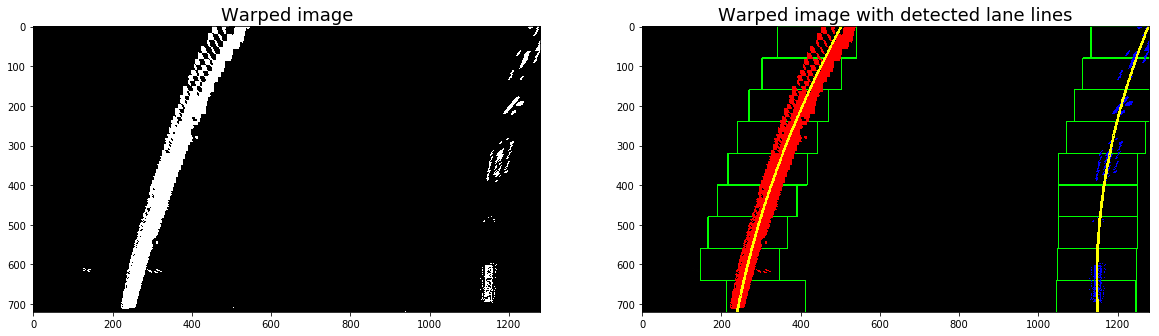

In [26]:
#Testing 
lines_fit, left_points, right_points, out_img = find_lane_lines(warped)
plots(warped, out_img, 'Warped image', 'Warped image with detected lane lines', (True, True), save = True)

#### Using previous values

It is not necessary to search lines from scratch for every frames, using sliding window method above. Instead we can utilize information from the detected lane line of the previous frame.

In [27]:
def use_previous_line(img, line_fits = None):
    
    #if it is first time, find a lines from scratch
    if line_fits is None:
        line_fits, _, _, _ = find_lane_lines(img)
    
    left_fit = line_fits[0]
    right_fit = line_fits[1]
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # If any of the lines could not be found, restart finding lines 
    if (leftx.size == 0 or rightx.size == 0):
        return detect_lines(img, return_img)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    for index in range(img.shape[0]):
        cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
        cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
    
    lines_fit, left_points, right_points, out_img = (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img.astype(int)
    
    return lines_fit, left_points, right_points, out_img

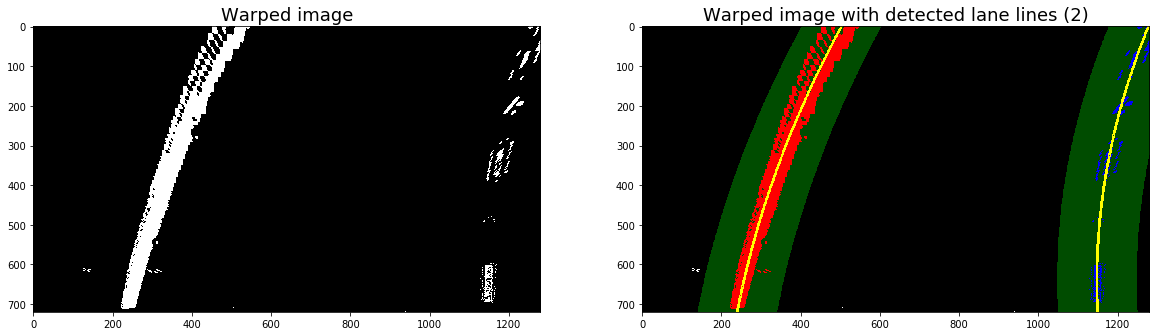

In [28]:
#Testing
lines_fit, left_points, right_points, out_img = use_previous_line(warped, lines_fit)
plots(warped, out_img, 'Warped image', 'Warped image with detected lane lines (2)', (True, True), save=True)

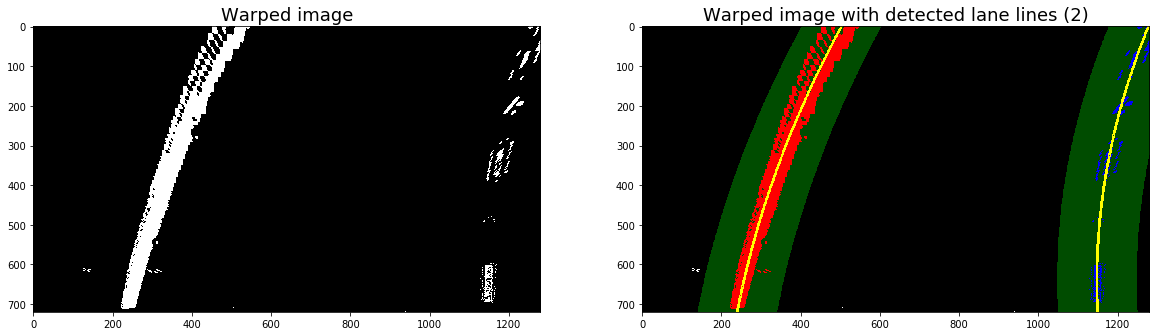

In [29]:
def pipeline(img):
    '''
    Incorporates all steps from distortion correction to lane line detection
    '''
    undist = dist_cor(img, mtx, dist_coef)
    thres_binary = threshold_pipe(undist)
    warped, M, Minv = pers_trans(thres_binary, 9, src, offset =100)
    lines_fit, left_points, right_points, out_img = use_previous_line(warped, line_fits = None)
    return lines_fit, left_points, right_points, out_img

lines_fit, _, _, out_img = pipeline(img)
plots(warped, out_img, 'Warped image', 'Warped image with detected lane lines (2)', (True, True))

### Lane curvature and vehicle offsets from center

In this module, we will calculate lane curvature in meter terms and vehicle position within the lane lines.

#### Radius for lane curvature

In [30]:
def measure_curvature_pixels(leftx, rightx, img_shape, xm_per_pix=3.7/800, ym_per_pix = 25/720):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**(3/2))/abs(2*left_fit[0])  ## Implement the calculation of the left line here
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**(3/2))/abs(2*right_fit[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad

# testing
left_curverad, right_curverad = measure_curvature_pixels(leftx=left_points[0], rightx=right_points[0], img_shape = img.shape)
print('Line curvatures: left {:.02f} meters, right {:.02f} meters.'.format(left_curverad , right_curverad))

Line curvatures: left 2197.63 meters, right 1577.36 meters.


#### Calculating vehicle offset

In [31]:
def car_offset(leftx, rightx, img_shape, xm_per_pix=3.7/800):
    '''
    Args:
        leftx: x position of left lane
        rightx: x position of the right lane
        img_shape: shape of image
        xm_per_pix: pixel value for per meter
    output: car offset from center
        '''
    ## Image mid horizontal position 
    mid_imgx = img_shape[1]//2
        
    ## Car position with respect to the lane
    car_pos = (leftx[-1] + rightx[-1])/2
    
    ## Horizontal car offset 
    offsetx = (mid_imgx - car_pos) * xm_per_pix
    return offsetx

#testing
offsetx = car_offset(leftx=left_points[0], rightx=right_points[0], img_shape=img.shape)
print ('Car offset from center: {:.04f} meters'.format(offsetx))

Car offset from center: -0.2509 meters


### Back to the original image

Now we will map detected lane lines back to the original image and display calculated road metrics on it as well.

#### Drawing lane lines on the original image

In [32]:
def draw_lane(img, warped_img, left_points, right_points, Minv):
    '''
    Args:
        img: original raw image
        warped_img: warped image
        left_points: points on the left lane
        right_points: points on the right lane
        Minv: Inverse distortion matrix from perspective transform
    outputs: original image with color-filled lane line
    '''
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

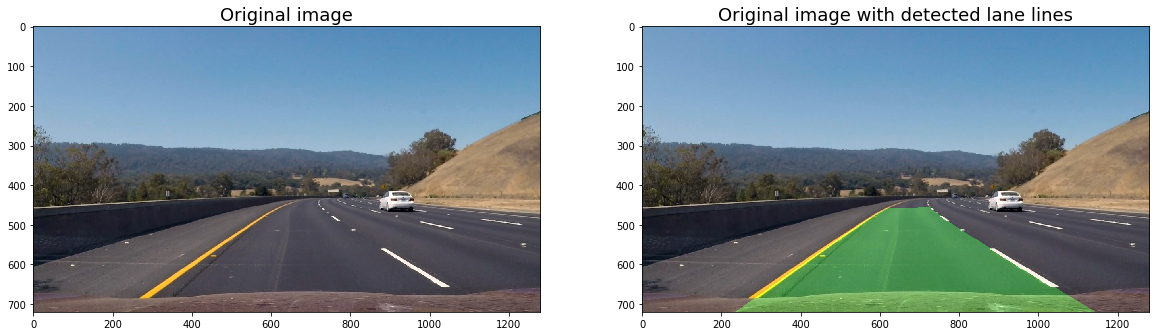

In [33]:
# Testing
img_lane = draw_lane(img, warped, left_points, right_points, Minv)
plots(img, img_lane, 'Original image' , 'Original image with detected lane lines', save = True)

#### Displaying metrics

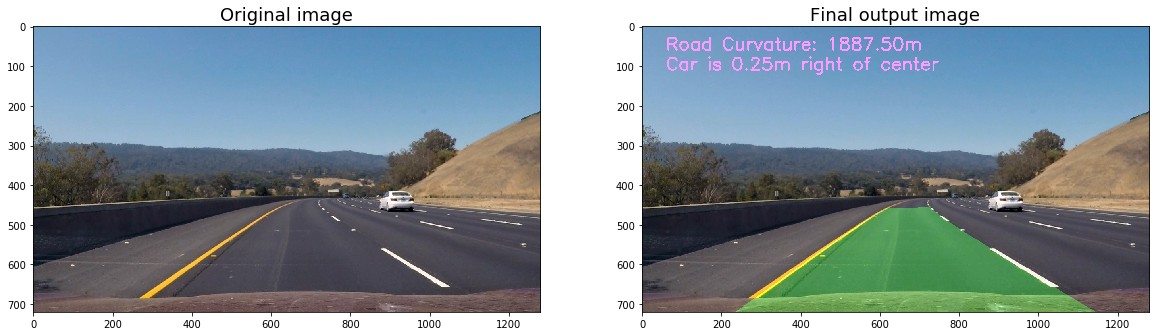

In [34]:
def add_metrics(img, leftx, rightx, xm_per_pix=3.7/800, ym_per_pix = 25/720):
    '''
    Args:
        img: original image with detected lane region 
        leftx: points on the left lane
        rightx: points on the right lane
        xm_per_pix: meters per pixel
        ym_per_pix: meters per pixel
    outputs: outputs image with detected lane regions and metrics displayed on it
        '''
    # Calculate radius of curvature
    curvature_rads = measure_curvature_pixels(leftx=leftx, rightx=rightx, img_shape=img.shape,
                                      xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix)
    # Calculate car offset
    offsetx = car_offset(leftx=leftx, rightx=rightx, img_shape=img.shape)

    # Display lane curvature
    out_img = img.copy()
    cv2.putText(out_img, 'Road Curvature: {:.2f}m'.format((curvature_rads[0]+curvature_rads[1])/2), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,155,255), 4)
    
    # Display car offset
    if offsetx < 0:    
        cv2.putText(out_img, 'Car is {:.2f}m right of center'.format(abs(offsetx)), 
                    (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,155,255), 4)
    else:    
        cv2.putText(out_img, 'Car is {:.2f}m left of center'.format(offsetx), 
                    (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,155,255), 4)
    
    return out_img

out_img = add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])
plots(img, out_img, 'Original image' , 'Final output image', save =True)

#saving final output as single image
plt.figure(figsize=(12,6))
plt.imshow(out_img)
plt.savefig('output_images/' + 'final output', bbox_inches = 'tight', pad_inches = 0)
plt.close()

### Output

It is been a long journey. Now it is time to test our pipeline on video.

#### Run pipeline in a video

In [30]:
class ProcessImage:
    def __init__(self, images_path):
        
        # Make a list of calibration images
        #images = glob.glob(images_path)

        # Calibrate camera
        self.ret, self.mtx, self.dist_coef, self.rvecs, self.tvecs = cameraCalib(images_path)
        self.lines_fit = None

    def __call__(self, img):
        
        # Undistord image
        undist = dist_cor(img, mtx, dist_coef)
        lines_fit, left_points, right_points, out_img = pipeline(img)
        
        # Warp the detected lane boundaries back onto the original image.
        img_lane = draw_lane(img, warped, left_points, right_points, Minv)
        
        # Add metrics to the output img
        out_img = add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])
            
        return out_img

In [31]:
input_video = 'project_video.mp4'
output_video = 'project_video_output.mp4'

## You may uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(0,5)
clip1 = VideoFileClip(input_video)
# Process video frames with our 'process_image' function
process_image = ProcessImage('camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)


...Camera calibration successfully done!...

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
Wall time: 6min 25s


In [32]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))

**End of the project**